# Implementation of MCMC algorithm from Chib 1996

**Reference:** Chib. S. (1996), "Calculating Posterior Distributions and Modal Estimates in Markov Mixture Models", _Journal of Econometrics_, 75, 79-97.  

## The generative model

I plan on simulating data similar to the _Poisson fetal data_ reported in section 4.1 of the paper.

The code below simply is a header for the Python code to come.

In [52]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np

We consider a HMM where 
$$s_t\in\{1,2\}$$
is a _hidden_ state variable controlling the rate 
$$\lambda_{s_t}\in \{\lambda_1,\lambda_2\}$$
of a Poisson random variable 
$$y_t$$
which is _observed_ on N=240 consecutive 5-second intervals.

The hidden process is a Markov Chain evolving according to the transition matrix
$$P$$

Select the two rates `lambda1`, `lambda2` (Hz), the hazard rate `h` (in [0,1]) of the hidden chain, and the total number `N` of observations, for generating simulated data (the sliders and boxes next to them are _interactive!_).

In [53]:
def f(lambda1=1.0, lambda2=2.0, h=1.0, N=240):
    return np.array([lambda1, lambda2, h, N])
w = interactive(f, lambda1=(0.0,20.0), lambda2=(0.0,20.0), h=(0.0,30.0),N=(100,1000))
display(w)

In [54]:
# print(w.kwargs)
print(w.result)

[   1.    2.    1.  240.]


We produce the observations here

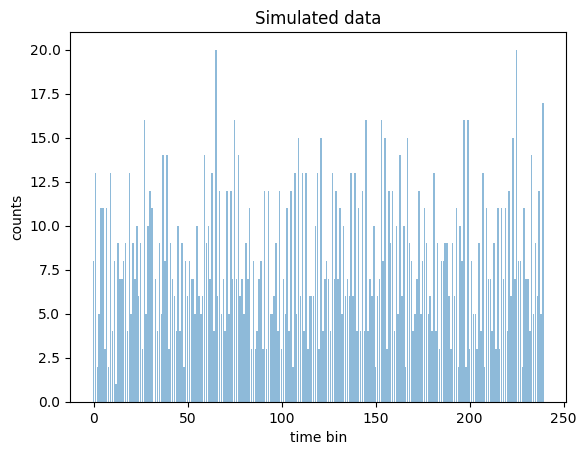

In [57]:
lambda1, lambda2, h, N = w.result
N = int(N)
states = np.array([lambda1, lambda2])
time = np.arange(N) + 1
y_pos = np.arange(len(time))
counts = np.zeros((len(time),1))

# function that switches the environment state that is given as argument
def switch(rate):
    try:
        if rate in states:
            if rate == states[0]:
                return states[1]
            else:
                return states[0]
        else:
            raise ValueError("Error in argument 'rate': must be an element of "
                             "'states'")
    except ValueError as err:
        print(err.args)

last_state = states[0]  # Force environment in state 1 at time 1
for t in np.arange(N):
    draw = np.random.uniform()
    if t == 0 or (draw > h):
        new_state = last_state
    else:
        new_state = switch(last_state)
        
    counts[t] = np.random.poisson(5*new_state) 
    last_state = new_state
 
plt.bar(y_pos, counts, align='center', alpha=0.5)
# plt.xticks(y_pos, time)
plt.xlabel('time bin')
plt.ylabel('counts')
plt.title('Simulated data')

plt.show()

In [56]:
def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
interactive_plot.layout.height = '350px'
interactive_plot